In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications import EfficientNetB0, DenseNet121, MobileNetV2, ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from PIL import Image
import seaborn as sns
from tensorflow.python.keras.saving.save import load_model

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-06-07 23:43:18.134069: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define parameters
IMAGE_SIZE = 224  # Standard image size for most pre-trained models
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
N_SPLITS = 5  

In [3]:
%cd /kaggle/working

/kaggle/working


In [4]:
!cp -r /kaggle/input/oral-cancer-images-for-classification ./home/quoc-vuong/Workspace/pycharm/hus/oral_cancer

In [5]:
%cd ./oral-cancer-images-for-classification

/kaggle/working/oral-cancer-images-for-classification


In [6]:
path1 = "./dataset"
os.rename(os.path.join(path1, "Oral Cancer photos"), os.path.join(path1, "cancer"))
os.rename(os.path.join(path1, "normal"), os.path.join(path1, "non_cancer"))
print(os.listdir(path1))

['cancer', 'non_cancer']


In [7]:
# Create directories for processed data
os.makedirs("./processed_data", exist_ok=True)
os.makedirs("./processed_data/0", exist_ok=True) # Non-cancer
os.makedirs("./processed_data/1", exist_ok=True) # Cancer
os.makedirs("./Croped", exist_ok=True)
os.makedirs("./models", exist_ok=True)
os.makedirs("./models/CustomCNN", exist_ok=True)

# Tiền xử lý

In [14]:
# Function to delete temporary images
def delete_temp_images(folder="Croped"):
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        if os.path.isfile(file_path):
            os.remove(file_path)

# Function to resize image to standard size
def resize_image(image_path):
    # Read original image
    image = cv2.imread(image_path)
    if image is None:
        return None
    # Resize image to standard size
    resized_image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    return resized_image

# Function to detect mouth region using color thresholding and contour detection
def detect_mouth_region(image_path):
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        return None
    
    # Convert to HSV color space for better color segmentation
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define red color range (for possible lesions or oral tissue)
    # We'll use two ranges as red wraps around the hue spectrum
    lower_red1 = np.array([0, 70, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 70, 50])
    upper_red2 = np.array([180, 255, 255])
    
    # Create masks for red regions
    mask1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
    red_mask = mask1 + mask2
    
    # Define pink color range (for oral mucosa)
    lower_pink = np.array([140, 30, 160])
    upper_pink = np.array([170, 255, 255])
    pink_mask = cv2.inRange(hsv_image, lower_pink, upper_pink)
    
    # Combine masks
    combined_mask = cv2.bitwise_or(red_mask, pink_mask)
    
    # Apply morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    
    # Find contours in the combined mask
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # If no contours found, return None
    if not contours:
        return None
    
    # Find the largest contour (likely to be the mouth region)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Create a bounding rectangle around the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Make the bounding box slightly larger to ensure we capture the entire mouth
    padding = 20  # pixels
    x = max(0, x - padding)
    y = max(0, y - padding)
    w = min(image.shape[1] - x, w + 2 * padding)
    h = min(image.shape[0] - y, h + 2 * padding)
    
    # Crop the image
    mouth_region = image[y:y+h, x:x+w]
    
    return mouth_region

# Alternative method: segment image using K-means and select the most likely oral region
def segment_oral_region(image_path, n_clusters=12):
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        return None
    
    # Reshape image for K-means (we need a 2D array of pixels)
    pixels = image.reshape((-1, 3))
    pixels = np.float32(pixels)
    
    # Define criteria for K-means
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    
    # Apply K-means
    _, labels, centers = cv2.kmeans(pixels, n_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Convert centers to uint8
    centers = np.uint8(centers)
    
    # Map each pixel to its corresponding center
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    
    # Convert to HSV to analyze hue values (helpful for identifying oral tissue)
    hsv_image = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2HSV)
    
    # Find the cluster that is most likely to be oral tissue
    # (We'll look for reddish/pinkish hues common in oral tissue)
    oral_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    
    for i in range(n_clusters):
        # Create mask for current cluster
        cluster_mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cluster_mask[labels.reshape(image.shape[:2]) == i] = 255
        
        # Calculate the average HSV value for this cluster
        cluster_hsv = hsv_image.copy()
        cluster_hsv[cluster_mask == 0] = 0
        non_zero_pixels = cluster_hsv[cluster_mask == 255]
        
        if len(non_zero_pixels) > 0:
            avg_hsv = np.mean(non_zero_pixels, axis=0)
            
            # Check if this is likely to be oral tissue (reddish/pinkish hue)
            if (0 <= avg_hsv[0] <= 10 or 160 <= avg_hsv[0] <= 180) and avg_hsv[1] > 50:
                oral_mask = cv2.bitwise_or(oral_mask, cluster_mask)
    
    # Find contours in the oral mask
    contours, _ = cv2.findContours(oral_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # If no contours found, return None
    if not contours:
        return None
    
    # Find the largest contour (likely to be the oral region)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Create a bounding rectangle around the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Make the bounding box slightly larger
    padding = 20  # pixels
    x = max(0, x - padding)
    y = max(0, y - padding)
    w = min(image.shape[1] - x, w + 2 * padding)
    h = min(image.shape[0] - y, h + 2 * padding)
    
    # Crop the image
    oral_region = image[y:y+h, x:x+w]
    
    return oral_region

# Save intermediate results for debugging
def save_debug_image(image, path, suffix):
    if image is not None:
        debug_path = os.path.join("debug_images", f"{os.path.basename(path)}_{suffix}.png")
        os.makedirs(os.path.dirname(debug_path), exist_ok=True)
        cv2.imwrite(debug_path, image)

# Enhanced process_dataset function
def process_dataset(source_dir, target_class, debug=False):
    if debug:
        os.makedirs("debug_images", exist_ok=True)
    
    processed_count = 0
    skipped_count = 0
    
    for img_file in os.listdir(source_dir):
        # Process only image files
        if not img_file.lower().endswith(('.jpg', '.png', '.webp', '.jpeg', '.jfif')):
            continue
            
        # Full path to the source image
        source_path = os.path.join(source_dir, img_file)
        
        # Try to detect mouth region
        mouth_region = detect_mouth_region(source_path)
        
        # If mouth detection failed, try the alternative segmentation approach
        if mouth_region is None or mouth_region.size == 0:
            mouth_region = segment_oral_region(source_path)
        
        # If both approaches failed, use the original image
        if mouth_region is None or mouth_region.size == 0:
            print(f"Warning: Could not detect oral region in {img_file}, using original image")
            mouth_region = cv2.imread(source_path)
            
        if mouth_region is None:
            print(f"Skipping {img_file}: Could not read image")
            skipped_count += 1
            continue
            
        # Save debug images if requested
        if debug:
            save_debug_image(mouth_region, source_path, "mouth_region")
        
        # Resize the detected region
        resized_image = cv2.resize(mouth_region, (IMAGE_SIZE, IMAGE_SIZE))
        
        # Save with original name but .png extension
        base, _ = os.path.splitext(img_file)
        out_name = base + ".png"
        out_path = os.path.join(f"processed_data/{target_class}", out_name)
        
        # Save the processed image
        cv2.imwrite(out_path, resized_image)
        processed_count += 1
    
    return processed_count, skipped_count

In [9]:
# Process cancer and non-cancer images
print("Processing cancer images...")
cancer_processed, cancer_skipped = process_dataset("./dataset/cancer", "1")
print(f"Processed {cancer_processed} cancer images, skipped {cancer_skipped}")

print("\nProcessing non-cancer images...")
noncancer_processed, noncancer_skipped = process_dataset("./dataset/non_cancer", "0")
print(f"Processed {noncancer_processed} non-cancer images, skipped {noncancer_skipped}")

Processing cancer images...


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: extra compressed data
libpng warning: iCCP: extra compressed data


Processed 685 cancer images, skipped 0

Processing non-cancer images...


libpng warning: iCCP: extra compressed data


Processed 553 non-cancer images, skipped 0


# Cross Validation

In [10]:
def create_cv_dataframe(n_splits=5):
    file_paths, labels = [], []
    
    # Class 0: Non-cancer
    class_dir = "processed_data/0"
    for fname in os.listdir(class_dir):
        if fname.endswith(('.png')):  
            full_path = os.path.join(class_dir, fname)
            file_paths.append(full_path)
            labels.append('non_cancer')
    
    # Class 1: Cancer
    class_dir = "processed_data/1"
    for fname in os.listdir(class_dir):
        if fname.endswith(('.png')):  
            full_path = os.path.join(class_dir, fname)
            file_paths.append(full_path)
            labels.append('cancer')
    
    # Create DataFrame
    df = pd.DataFrame({'filepath': file_paths, 'label': labels})
    
    # Setup stratified k-fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    df['fold'] = -1
    
    # Assign fold numbers
    for fold, (_, val_idx) in enumerate(skf.split(df, df['label'])):
        df.loc[val_idx, 'fold'] = fold
    
    return df

In [11]:
print("\nCreating cross-validation splits...")
df = create_cv_dataframe(N_SPLITS)
df.to_csv('./dataset_cv.csv', index=False)


Creating cross-validation splits...


In [12]:
# Print class distribution
print("\nClass distribution in dataset:")
print(df['label'].value_counts())

# Print fold distribution
print("\nFold distribution:")
for fold in range(N_SPLITS):
    fold_df = df[df['fold'] == fold]
    class_counts = fold_df['label'].value_counts().to_dict()
    non_cancer_count = class_counts.get('non_cancer', 0)
    cancer_count = class_counts.get('cancer', 0)
    print(f"Fold {fold}: {len(fold_df)} samples | non_cancer: {non_cancer_count}, cancer: {cancer_count}")


Class distribution in dataset:
label
cancer        685
non_cancer    553
Name: count, dtype: int64

Fold distribution:
Fold 0: 248 samples | non_cancer: 111, cancer: 137
Fold 1: 248 samples | non_cancer: 111, cancer: 137
Fold 2: 248 samples | non_cancer: 111, cancer: 137
Fold 3: 247 samples | non_cancer: 110, cancer: 137
Fold 4: 247 samples | non_cancer: 110, cancer: 137


# Data Generators

In [13]:
# Configure data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Only rescale validation data
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create data generators for a fold
def create_generators(train_df, val_df):
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filepath',
        y_col='label',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        classes=['non_cancer', 'cancer'],  # Ensure correct mapping
        shuffle=True
    )
    
    validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filepath',
        y_col='label',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        classes=['non_cancer', 'cancer'],
        shuffle=False
    )
    
    return train_generator, validation_generator

# Calculate class weights to handle imbalanced data
def calculate_class_weights(train_generator):
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train_generator.classes),
        y=train_generator.classes
    )
    return dict(enumerate(class_weights))

# Custom CNN

## Kiến trúc

In [14]:
def create_model():
    model = Sequential()
    
    # First convolutional block
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Second convolutional block
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Third convolutional block
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    
    # Flatten and dense layers
    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=0.25))
    model.add(Dense(units=1, activation='sigmoid'))
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Lưu trữ kết quả các fold
all_scores = []
histories = []
best_models = []

## Huấn luyện

In [15]:
# Storage for results
all_scores = []
histories = []
best_models = []

# Cross-validation loop
for fold in range(N_SPLITS):
    print(f"\n{'='*40}")
    print(f"Training Fold {fold + 1}/{N_SPLITS}")
    print(f"{'='*40}")
    
    # Split data
    train_df = df[df['fold'] != fold]
    val_df = df[df['fold'] == fold]
    
    # Create generators
    train_gen, val_gen = create_generators(train_df, val_df)
    
    # Calculate class weights
    class_weights = calculate_class_weights(train_gen)
    print(f"Class weights for fold {fold}: {class_weights}")
    
    # Initialize model
    model = create_model()
    
    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    checkpoint = ModelCheckpoint(
        f"./models/CustomCNN/best_model_fold{fold}.keras",
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy', 
        factor=0.5, 
        patience=3,
        verbose=1, 
        mode='max', 
        min_lr=0.00001
    )
    
    # Training
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        verbose=1
    )
    
    # Save history and evaluate
    histories.append(history)
    best_models.append(tf.keras.models.load_model(f"./models/CustomCNN/best_model_fold{fold}.keras"))
    
    # Evaluate on validation set
    loss, acc = best_models[-1].evaluate(val_gen, verbose=0)
    print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {acc:.4f}\n")

    # Reset and predict
    val_gen.reset()
    y_pred = model.predict(val_gen, verbose=0)
    y_pred_class = np.round(y_pred).flatten().astype(int)
    y_true = val_gen.labels

    # Tính toán các chỉ số
    clf_report = classification_report(y_true, y_pred_class, target_names=['non_cancer', 'cancer'], output_dict=True)

    # Lưu kết quả chi tiết
    fold_metrics = {
        'fold': fold,
        'loss': loss,
        'accuracy': acc,
        'precision': clf_report['weighted avg']['precision'],
        'recall': clf_report['weighted avg']['recall'],
        'f1_score': clf_report['weighted avg']['f1-score'],
        'class_0_precision': clf_report['non_cancer']['precision'],
        'class_0_recall': clf_report['non_cancer']['recall'],
        'class_1_precision': clf_report['cancer']['precision'],
        'class_1_recall': clf_report['cancer']['recall'],
    }
    all_scores.append(fold_metrics)

    # In thông tin chi tiết cho từng fold
    print(f"\nClassification Report Fold {fold}:")
    print(classification_report(y_true, y_pred_class, target_names=['non_cancer', 'cancer']))

    print(f"Confusion Matrix Fold {fold}:")
    print(confusion_matrix(y_true, y_pred_class))
    print("\n" + "-"*50 + "\n")


Training Fold 1/5
Found 990 validated image filenames belonging to 2 classes.
Found 248 validated image filenames belonging to 2 classes.
Class weights for fold 0: {0: 1.1199095022624435, 1: 0.9032846715328468}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747099260.291955      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747099260.292604      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747099269.668295      64 service.cc:148] XLA service 0x7bbaf0007730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747099269.669039      64 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747099269.669060      64 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747099270.042260      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.6797 - loss: 0.6629 

I0000 00:00:1747099279.251442      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 728ms/step - accuracy: 0.5454 - loss: 0.6880 - val_accuracy: 0.4758 - val_loss: 0.6941 - learning_rate: 1.0000e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 352ms/step - accuracy: 0.5426 - loss: 0.6860 - val_accuracy: 0.6129 - val_loss: 0.6713 - learning_rate: 1.0000e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 351ms/step - accuracy: 0.6233 - loss: 0.6670 - val_accuracy: 0.6694 - val_loss: 0.6518 - learning_rate: 1.0000e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 352ms/step - accuracy: 0.6560 - loss: 0.6506 - val_accuracy: 0.6734 - val_loss: 0.6215 - learning_rate: 1.0000e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 341ms/step - accuracy: 0.6305 - loss: 0.6362 - val_accuracy: 0.6290 - val_loss: 0.6407 - learning_rate: 1.0000e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 338ms/step - accuracy: 0.6914 - loss: 0.6320 - val_accuracy: 0.6452 - val_loss: 0.6299 - learning_rate: 1.0000e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 353ms/step - accuracy: 0.65

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 421ms/step - accuracy: 0.5325 - loss: 0.6945 - val_accuracy: 0.4476 - val_loss: 0.6925 - learning_rate: 1.0000e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 354ms/step - accuracy: 0.5574 - loss: 0.6848 - val_accuracy: 0.6250 - val_loss: 0.6604 - learning_rate: 1.0000e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 342ms/step - accuracy: 0.5805 - loss: 0.6767 - val_accuracy: 0.5887 - val_loss: 0.6600 - learning_rate: 1.0000e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 357ms/step - accuracy: 0.6133 - loss: 0.6566 - val_accuracy: 0.7016 - val_loss: 0.6156 - learning_rate: 1.0000e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 344ms/step - accuracy: 0.6765 - loss: 0.6311 - val_accuracy: 0.7016 - val_loss: 0.5876 - learning_rate: 1.0000e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 351ms/step - accuracy: 0.6808 - loss: 0.6172 - val_accuracy: 0.7177 - val_loss: 0.5759 - learning_rate: 1.0000e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 358ms/step - accuracy: 0.73

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 418ms/step - accuracy: 0.5019 - loss: 0.7072 - val_accuracy: 0.5524 - val_loss: 0.6830 - learning_rate: 1.0000e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 350ms/step - accuracy: 0.5630 - loss: 0.6895 - val_accuracy: 0.5927 - val_loss: 0.6863 - learning_rate: 1.0000e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 359ms/step - accuracy: 0.5360 - loss: 0.6852 - val_accuracy: 0.6331 - val_loss: 0.6573 - learning_rate: 1.0000e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 351ms/step - accuracy: 0.6169 - loss: 0.6664 - val_accuracy: 0.6815 - val_loss: 0.6426 - learning_rate: 1.0000e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 350ms/step - accuracy: 0.6275 - loss: 0.6539 - val_accuracy: 0.6411 - val_loss: 0.6492 - learning_rate: 1.0000e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 340ms/step - accuracy: 0.6818 - loss: 0.6181 - val_accuracy: 0.6492 - val_loss: 0.6576 - learning_rate: 1.0000e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 355ms/step - accuracy: 0.65

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/31 ━━━━━━━━━━━━━━━━━━━━ 4s 384ms/step - accuracy: 0.5102 - loss: 0.7011

2025-05-13 01:54:00.955046: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,32,222,222]{3,2,1,0}, f32[31,32,220,220]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-13 01:54:01.308118: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.353176158s
Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,32,222,222]{3,2,1,0}, f32[31,32,220,220]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","c

31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 732ms/step - accuracy: 0.5242 - loss: 0.6985 - val_accuracy: 0.5628 - val_loss: 0.6886 - learning_rate: 1.0000e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 348ms/step - accuracy: 0.5211 - loss: 0.6911 - val_accuracy: 0.4575 - val_loss: 0.6951 - learning_rate: 1.0000e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 352ms/step - accuracy: 0.5342 - loss: 0.6792 - val_accuracy: 0.5992 - val_loss: 0.6586 - learning_rate: 1.0000e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 354ms/step - accuracy: 0.5943 - loss: 0.6767 - val_accuracy: 0.6599 - val_loss: 0.6344 - learning_rate: 1.0000e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 350ms/step - accuracy: 0.6280 - loss: 0.6477 - val_accuracy: 0.7126 - val_loss: 0.5937 - learning_rate: 1.0000e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 352ms/step - accuracy: 0.6371 - loss: 0.6358 - val_accuracy: 0.7530 - val_loss: 0.5746 - learning_rate: 1.0000e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 350ms/step - accuracy: 0.69

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 401ms/step - accuracy: 0.5184 - loss: 0.6911 - val_accuracy: 0.4494 - val_loss: 0.6930 - learning_rate: 1.0000e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 353ms/step - accuracy: 0.5366 - loss: 0.6888 - val_accuracy: 0.6154 - val_loss: 0.6770 - learning_rate: 1.0000e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 348ms/step - accuracy: 0.5770 - loss: 0.6781 - val_accuracy: 0.6437 - val_loss: 0.6486 - learning_rate: 1.0000e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 354ms/step - accuracy: 0.6167 - loss: 0.6574 - val_accuracy: 0.6640 - val_loss: 0.6243 - learning_rate: 1.0000e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 353ms/step - accuracy: 0.6547 - loss: 0.6270 - val_accuracy: 0.7004 - val_loss: 0.6067 - learning_rate: 1.0000e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 337ms/step - accuracy: 0.6722 - loss: 0.6244 - val_accuracy: 0.6518 - val_loss: 0.6232 - learning_rate: 1.0000e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 354ms/step - accuracy: 0.70

## Đánh giá

In [16]:
# Phân tích kết quả cross-validation
print("\nCross-validation Results:")
results_df = pd.DataFrame(all_scores)
print(results_df.round(4))

# Thêm thống kê tổng hợp
mean_metrics = results_df.mean(numeric_only=True)
std_metrics = results_df.std(numeric_only=True)

print("\nMean metrics:")
print(mean_metrics.round(4))
print("\nStandard deviation:")
print(std_metrics.round(4))


Cross-validation Results:
   fold    loss  accuracy  precision  recall  f1_score  class_0_precision  \
0     0  0.4135    0.8548     0.8440  0.8427    0.8417             0.8600   
1     1  0.4767    0.7944     0.7903  0.7903    0.7903             0.7658   
2     2  0.4683    0.8226     0.8143  0.8145    0.8139             0.8095   
3     3  0.4489    0.8259     0.8148  0.8138    0.8123             0.8265   
4     4  0.4957    0.7895     0.7769  0.7773    0.7770             0.7570   

   class_0_recall  class_1_precision  class_1_recall  
0          0.7748             0.8311          0.8978  
1          0.7658             0.8102          0.8102  
2          0.7658             0.8182          0.8540  
3          0.7364             0.8054          0.8759  
4          0.7364             0.7929          0.8102  

Mean metrics:
fold                 2.0000
loss                 0.4606
accuracy             0.8174
precision            0.8081
recall               0.8077
f1_score             0.80

## Training history

In [17]:
def plot_training_history(histories, metrics=['accuracy', 'loss']):
    min_epochs = min(len(h.history['accuracy']) for h in histories)
    
    plt.figure(figsize=(15, 6))
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, len(metrics), i+1)
        
        # Plot individual fold histories
        for j, h in enumerate(histories):
            plt.plot(h.history[metric][:min_epochs], alpha=0.3, label=f'Fold {j+1} Train')
            plt.plot(h.history[f'val_{metric}'][:min_epochs], linestyle='--', alpha=0.3, 
                     label=f'Fold {j+1} Val')
        
        # Plot average
        train_avg = np.mean([h.history[metric][:min_epochs] for h in histories], axis=0)
        val_avg = np.mean([h.history[f'val_{metric}'][:min_epochs] for h in histories], axis=0)
        
        plt.plot(train_avg, color='black', linewidth=2, label='Average Train')
        plt.plot(val_avg, color='red', linewidth=2, linestyle='--', label='Average Val')
        
        plt.title(f'{metric.capitalize()} across Folds (First {min_epochs} Epochs)')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

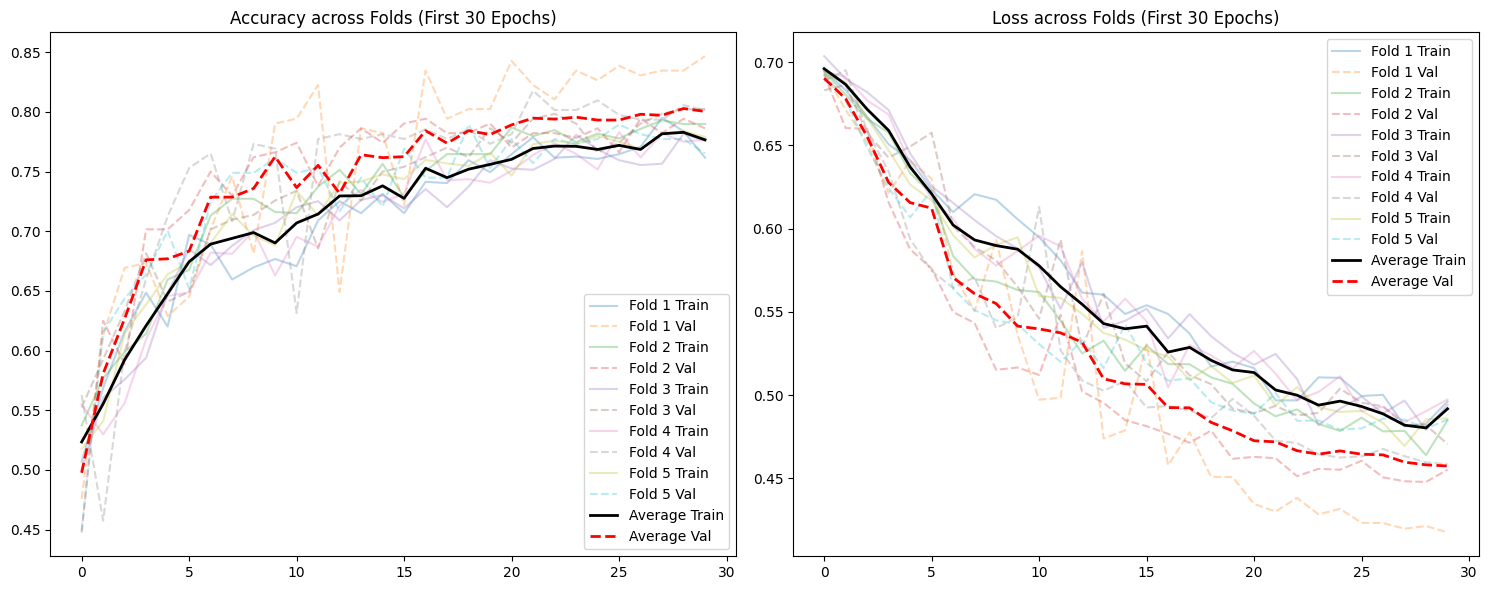


Số epochs của từng fold:
Fold 1: 48 epochs
Fold 2: 50 epochs
Fold 3: 41 epochs
Fold 4: 50 epochs
Fold 5: 30 epochs


In [18]:
plot_training_history(histories)

# Thêm phần này để debug
print("\nSố epochs của từng fold:")
for i, h in enumerate(histories):
    print(f"Fold {i+1}: {len(h.history['accuracy'])} epochs")

## Save best model

In [19]:
best_fold = np.argmax([score['accuracy'] for score in all_scores])
best_model = best_models[best_fold]
best_model.save('./models/CustomCNN/best_model.keras')
print(f"\nSaved best model from Fold {best_fold+1} with validation accuracy {all_scores[best_fold]['accuracy']:.4f}")


Saved best model from Fold 1 with validation accuracy 0.8548


## Visualize predictions

In [20]:
def visualize_predictions(model, val_df, num_samples=5):
    plt.figure(figsize=(15, num_samples * 3))
    samples = val_df.sample(num_samples)

    for i, (_, row) in enumerate(samples.iterrows()):
        # 1) Load và preprocess ảnh gốc
        img = load_img(row['filepath'], target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # 2) Dự đoán
        pred = model.predict(img_array)[0][0]
        pred_label = "Cancer" if pred > 0.5 else "Non-Cancer"
        true_label = row['label']

        # 3) Vẽ ảnh gốc và kết quả
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label} ({pred:.2f})")
        plt.axis('off')

        # 4) Thử lấy ROI: ưu tiên detect_mouth_region, nếu None thì segment_oral_region
        mouth = detect_mouth_region(row['filepath'])
        if mouth is None or mouth.size == 0:
            mouth = segment_oral_region(row['filepath'])
        if mouth is not None and mouth.size > 0:
            roi = cv2.cvtColor(mouth, cv2.COLOR_BGR2RGB)
            plt.subplot(num_samples, 2, 2*i + 2)
            plt.imshow(roi)
            plt.title("Segmented ROI")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


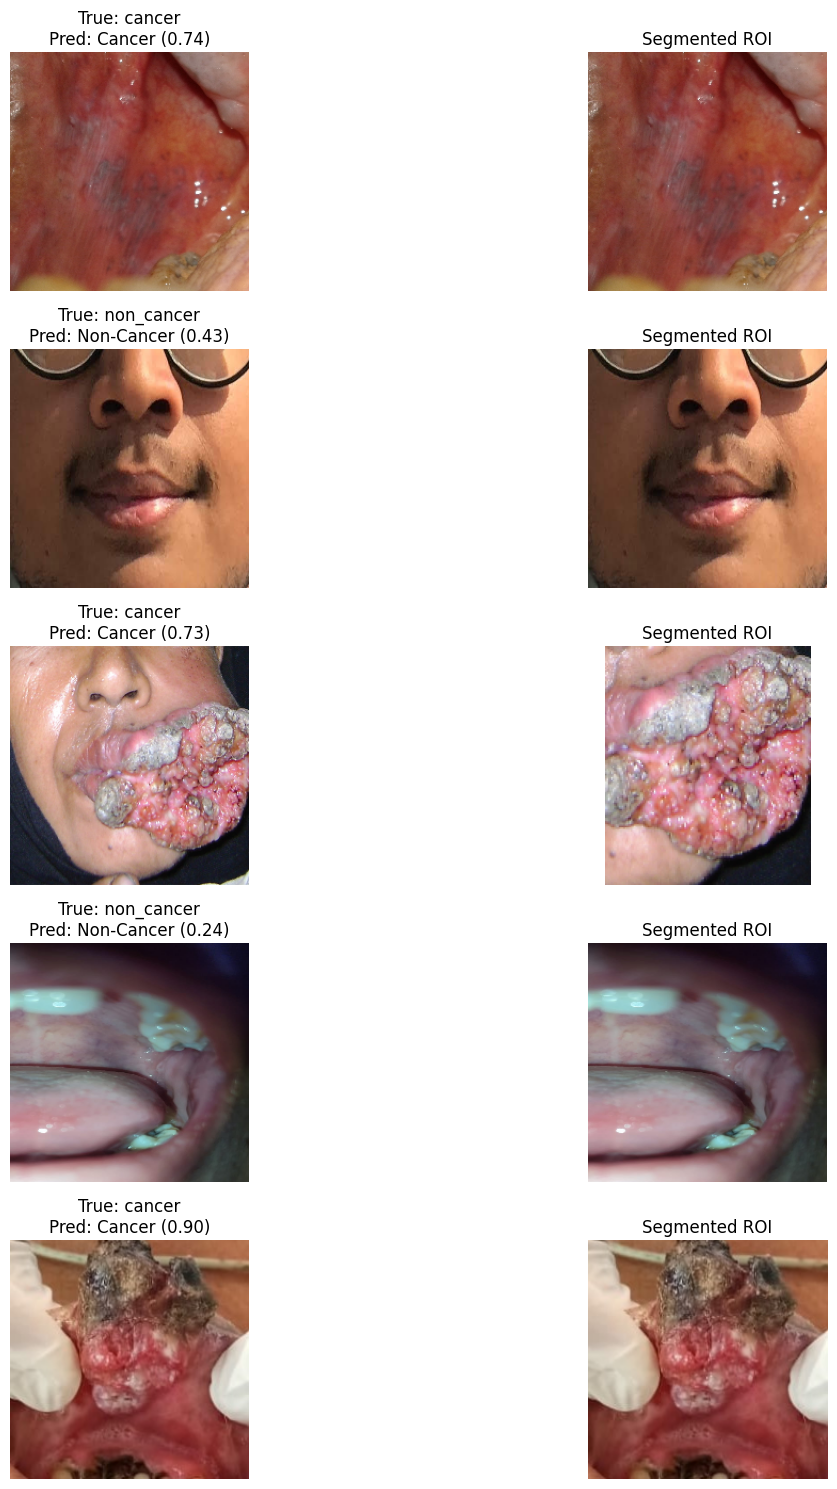

In [21]:
# Load best model
best_model = tf.keras.models.load_model('./models/CustomCNN/best_model.keras')

# Visualize predictions on validation samples
val_df = df[df['fold'] == best_fold]
visualize_predictions(best_model, val_df, num_samples=5)

## Thử trên ảnh mới

In [24]:
def preprocess_image_for_prediction(image_path):
    # 1) Thử detect ROI
    mouth = detect_mouth_region(image_path)
    if mouth is None or mouth.size == 0:
        mouth = segment_oral_region(image_path)
    if mouth is None or mouth.size == 0:
        return None

    # 2) Resize và normalize
    resized = cv2.resize(mouth, (IMAGE_SIZE, IMAGE_SIZE))
    img_array = resized.astype('float32') / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_image(model, image_path):
    img_array = preprocess_image_for_prediction(image_path)
    if img_array is None:
        return "Error processing image", 0.0

    pred = model.predict(img_array)[0][0]
    if pred > 0.5:
        return "Oral Cancer", pred
    else:
        return "Normal", 1 - pred

def test_new_image(image_path):
    class_label, confidence = predict_image(best_model, image_path)

    # Hiển thị ảnh gốc
    orig = cv2.imread(image_path)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(orig)
    plt.title(f"Prediction: {class_label}\nConfidence: {confidence:.2f}")
    plt.axis('off')

    # Hiển thị ROI nếu có
    mouth = detect_mouth_region(image_path)
    if mouth is None or mouth.size == 0:
        mouth = segment_oral_region(image_path)
    if mouth is not None and mouth.size > 0:
        roi = cv2.cvtColor(mouth, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 2, 2)
        plt.imshow(roi)
        plt.title("Segmented ROI")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


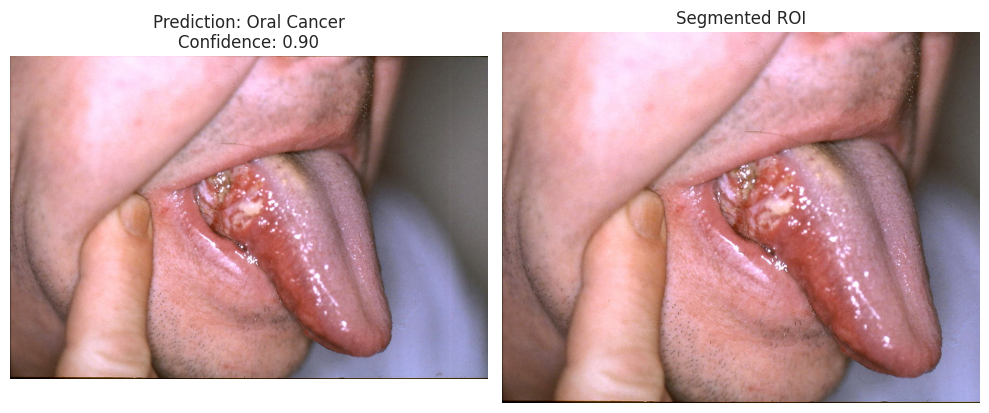

In [43]:
test_image_path = "/kaggle/input/oral-cancer-lips-and-tongue-images/OralCancer/cancer/1200px-ZungenCa2a.jpg"
test_new_image(test_image_path)